<a href="https://colab.research.google.com/github/Mateo289/Signal_theory/blob/main/12_Febrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo CSV cargado exitosamente.
Número de puntos en la señal: 301
Frecuencia de muestreo: 1000.0000 Hz
Frecuencia mínima: 3.3223 Hz
Frecuencia máxima: 498.3389 Hz
Ingresa la frecuencia mínima (Hz) a filtrar: 60
Ingresa la frecuencia máxima (Hz) a filtrar: 200
Filtro seleccionado: de 60.0 Hz a 200.0 Hz


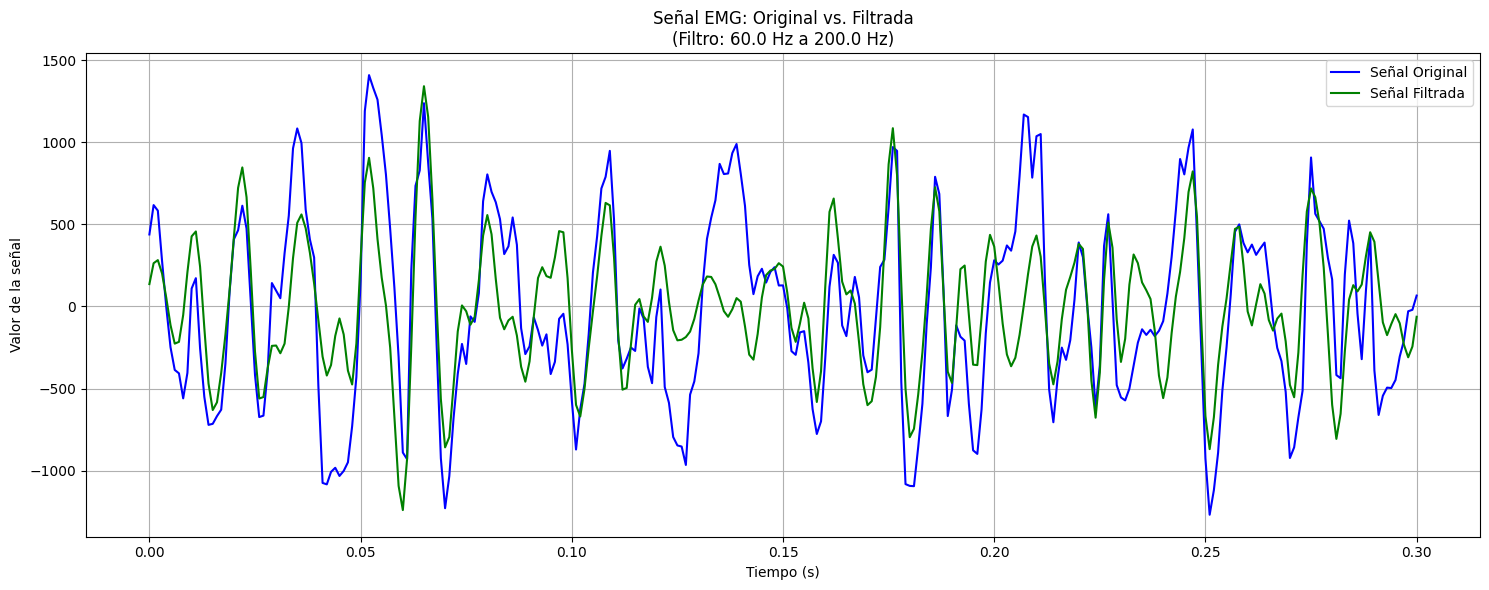

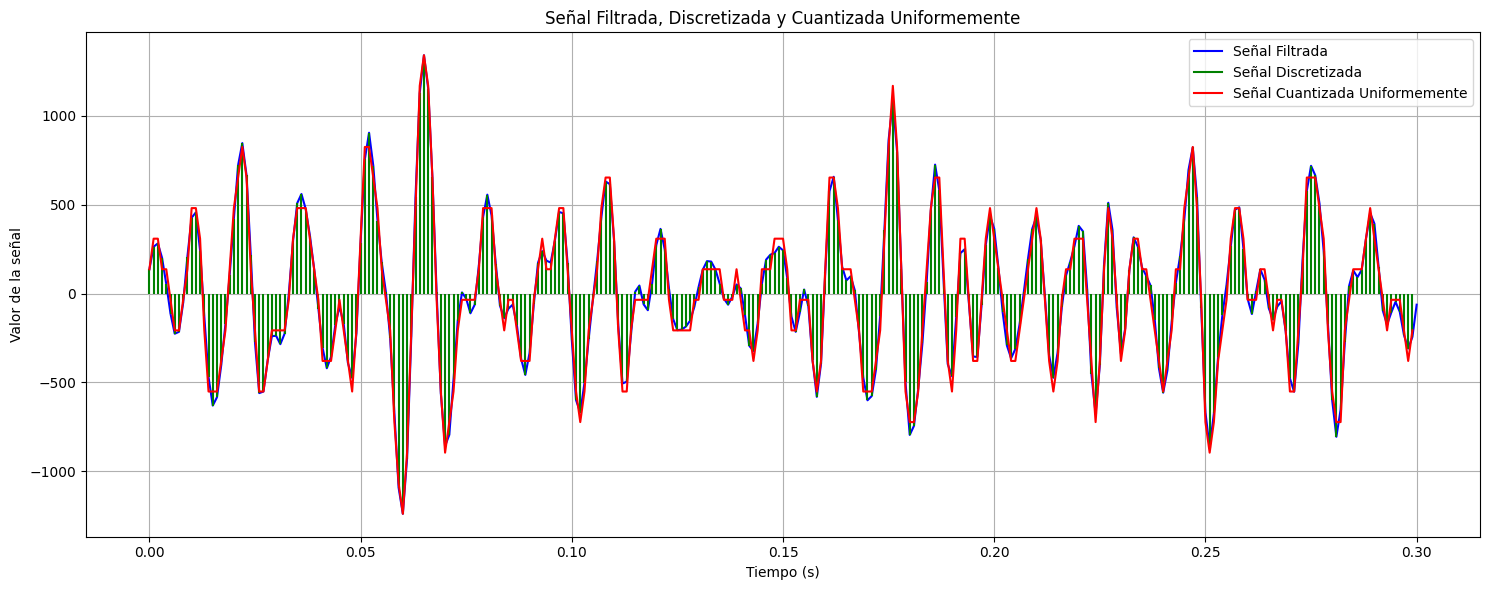

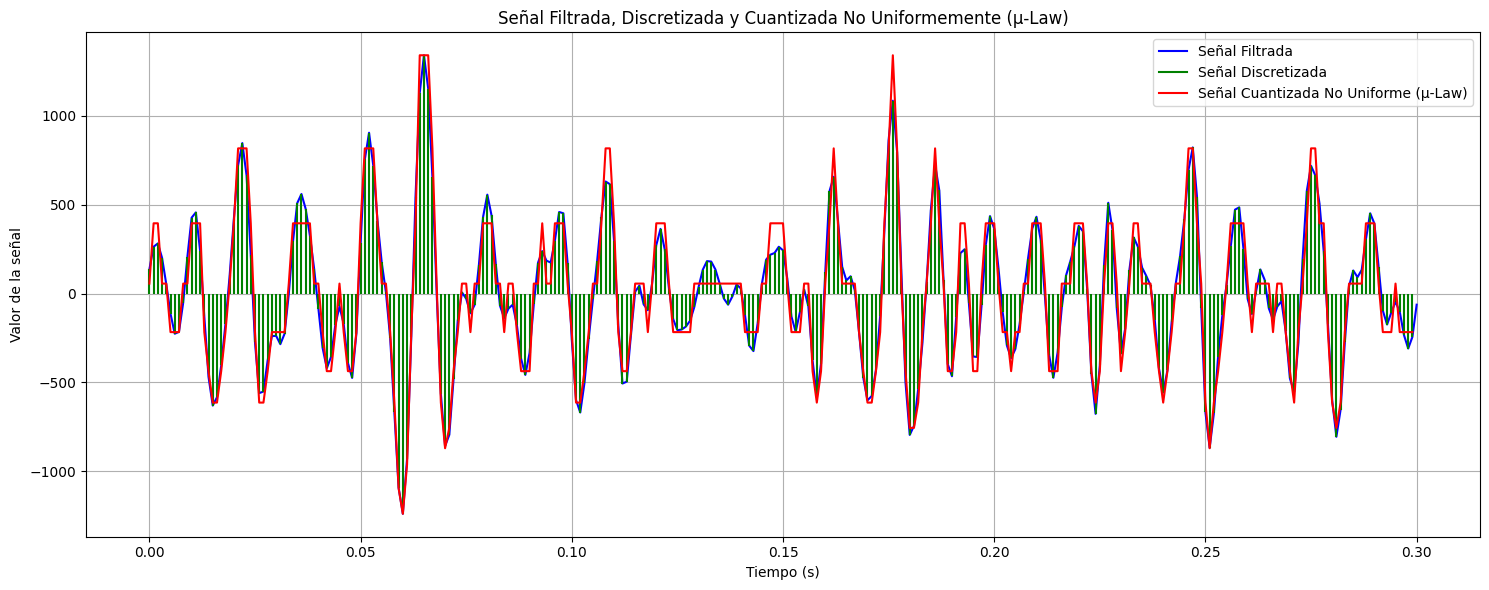

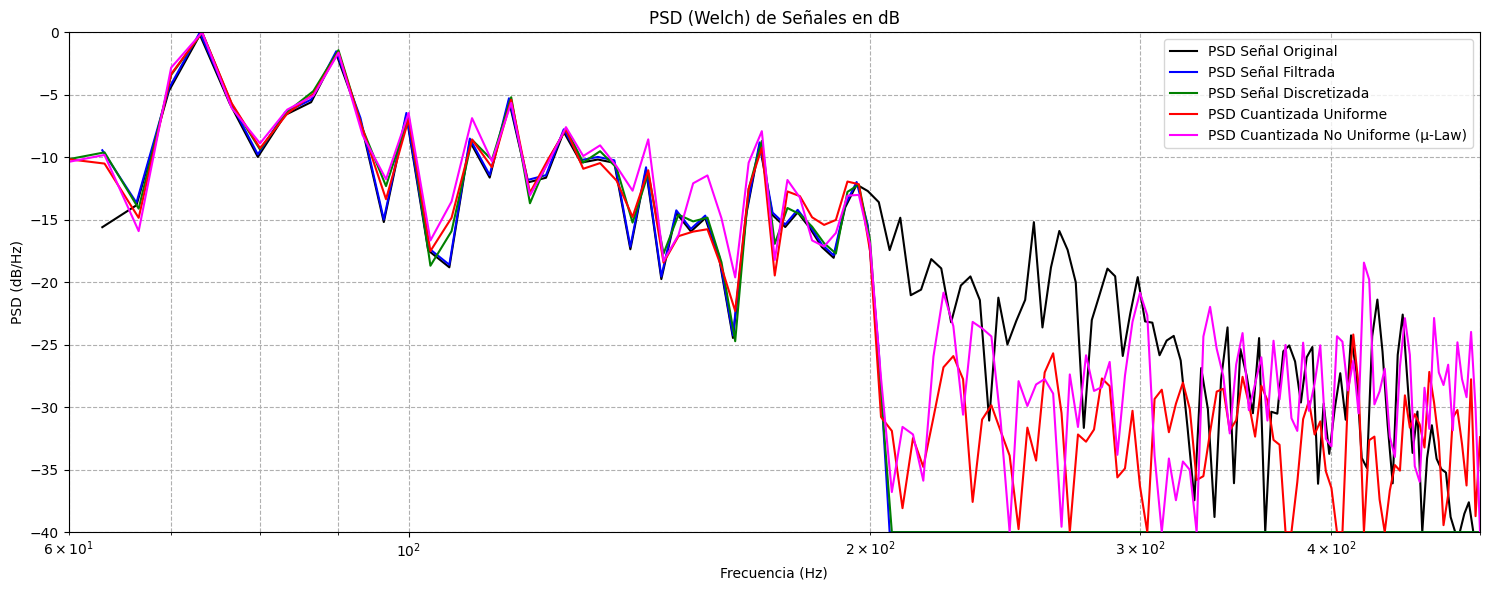

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.fftpack import fft, fftfreq, ifft
from scipy.signal import welch

# =============================================================================
# Clase para procesamiento en dominio del tiempo (carga, filtrado y gráfica)
# =============================================================================
class TimeDomainProcessor:
    """
    Procesa la señal en el dominio del tiempo:
      - Monta Google Drive y carga la señal desde un CSV.
      - Filtra la señal en un intervalo de tiempo especificado.
      - Calcula la FFT y aplica un filtro pasabanda.
      - Grafica la señal original y la señal filtrada (superpuestas).
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar

        # Variables de la señal y procesamiento
        self.tiempo = None
        self.señal = None
        self.tiempo_filtrado = None
        self.señal_filtrada = None
        self.N_filtrado = None
        self.T = None
        self.fs = None
        self.y_f = None
        self.frecuencias = None
        self.f_min = None
        self.f_max = None
        self.y_f_filtrado = None
        self.señal_filtrada_freq = None

    def mount_drive(self):
        """Monta Google Drive para acceder al archivo CSV."""
        drive.mount('/content/drive')

    def load_and_filter(self):
        """
        Carga el CSV y filtra la señal hasta el tiempo especificado.
        Se esperan las columnas 'Tiempo (ms)' y 'Datos Columna 2'.
        """
        try:
            datos = pd.read_csv(self.csv_path)
            print("Archivo CSV cargado exitosamente.")
        except Exception as e:
            print(f"Error al cargar el archivo CSV: {e}")
            exit()

        if 'Tiempo (ms)' in datos.columns and 'Datos Columna 2' in datos.columns:
            datos['Tiempo (ms)'] = pd.to_numeric(datos['Tiempo (ms)'], errors='coerce')
            self.tiempo = datos['Tiempo (ms)'].values
            self.señal = datos['Datos Columna 2'].values

            # Filtrar la señal hasta el tiempo especificado
            mask = self.tiempo <= self.tiempo_a_graficar
            self.tiempo_filtrado = self.tiempo[mask]
            self.señal_filtrada = self.señal[mask]
            self.N_filtrado = len(self.señal_filtrada)
            print(f"Número de puntos en la señal: {self.N_filtrado}")

            # Calcular el intervalo medio de muestreo y la frecuencia
            self.T = np.mean(np.diff(self.tiempo_filtrado))
            self.fs = 1 / self.T
            print(f"Frecuencia de muestreo: {self.fs:.4f} Hz")
        else:
            print("Error: El CSV no contiene las columnas requeridas ('Tiempo (ms)' y 'Datos Columna 2').")
            exit()

    def compute_fft(self):
        """Calcula la FFT de la señal filtrada y obtiene las frecuencias asociadas."""
        self.y_f = fft(self.señal_filtrada)
        self.frecuencias = fftfreq(self.N_filtrado, d=self.T)
        positive_freqs = np.abs(self.frecuencias[self.frecuencias > 0])
        if positive_freqs.size > 0:
            frecuencia_min = np.min(positive_freqs)
            frecuencia_max = np.max(positive_freqs)
        else:
            frecuencia_min, frecuencia_max = 0, 0
        print(f"Frecuencia mínima: {frecuencia_min:.4f} Hz")
        print(f"Frecuencia máxima: {frecuencia_max:.4f} Hz")

    def apply_bandpass_filter(self, f_min, f_max):
        """
        Aplica un filtro pasabanda en el dominio de la frecuencia entre f_min y f_max.
        """
        self.f_min = f_min
        self.f_max = f_max
        print(f"Filtro seleccionado: de {f_min} Hz a {f_max} Hz")
        filtro_mask = (np.abs(self.frecuencias) >= f_min) & (np.abs(self.frecuencias) <= f_max)
        self.y_f_filtrado = self.y_f * filtro_mask
        self.señal_filtrada_freq = np.real(ifft(self.y_f_filtrado))

    def plot_time_domain(self):
        """Grafica la señal original (filtrada en el tiempo) y la señal filtrada (obtenida tras aplicar la FFT y filtro)."""
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada, color='b', label='Señal Original')
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, color='g', label='Señal Filtrada')
        plt.title(f'Señal EMG: Original vs. Filtrada\n(Filtro: {self.f_min} Hz a {self.f_max} Hz)')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor de la señal')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# =============================================================================
# Clase para discretización y cuantización (uniforme y μ‑Law)
# =============================================================================
class DiscreteQuantProcessor:
    """
    Procesa la señal en el dominio discreto:
      - Discretiza la señal filtrada mediante interpolación lineal.
      - Aplica cuantización uniforme y no uniforme (μ‑Law).
      - Genera las gráficas de la señal discretizada y cuantizada.
    """
    def __init__(self, tiempo_filtrado, señal_filtrada_freq):
        self.tiempo_filtrado = tiempo_filtrado
        self.señal_filtrada_freq = señal_filtrada_freq
        self.sampling_rate = None

    def discretize_signal(self, sampling_rate=1000):
        """
        Discretiza la señal a una tasa de muestreo especificada.
        Devuelve el vector de tiempos discretos y la señal discretizada.
        """
        self.sampling_rate = sampling_rate
        sampling_period = 1 / sampling_rate
        tiempo_discreto = np.arange(self.tiempo_filtrado[0], self.tiempo_filtrado[-1], sampling_period)
        señal_filtrada_discreta = np.interp(tiempo_discreto, self.tiempo_filtrado, self.señal_filtrada_freq)
        return tiempo_discreto, señal_filtrada_discreta

    @staticmethod
    def quantize_uniform(x, q_min, q_max, q_level):
        """
        Realiza la cuantización uniforme de la señal.
        """
        x_normalize = (x - q_min) * (q_level - 1) / (q_max - q_min)
        x_normalize = np.clip(x_normalize, 0, q_level - 1)
        x_quant = np.round(x_normalize) * (q_max - q_min) / (q_level - 1) + q_min
        return x_quant

    @staticmethod
    def quantize_mu_law(signal, L=16, mu=255, x_min=None, x_max=None):
        """
        Realiza la cuantización no uniforme utilizando la companding μ‑Law.
        """
        if x_min is None:
            x_min = signal.min()
        if x_max is None:
            x_max = signal.max()
        x_norm = (signal - x_min) / (x_max - x_min)
        companded = np.log1p(mu * x_norm) / np.log1p(mu)
        q_companded = np.round(companded * (L - 1)) / (L - 1)
        q_nonuniform = (np.expm1(q_companded * np.log1p(mu)) / mu) * (x_max - x_min) + x_min
        return q_nonuniform

    def plot_discretized_quantized(self, tiempo_discreto, señal_filtrada_discreta, señal_quant_uniform):
        """
        Grafica la señal filtrada, la versión discretizada y la cuantizada de forma uniforme.
        """
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Señal Filtrada')
        markerline, stemlines, baseline = plt.stem(
            tiempo_discreto,
            señal_filtrada_discreta,
            linefmt='g-',
            markerfmt=' ',
            basefmt=' '
        )
        baseline.set_visible(False)
        plt.plot([], [], 'g-', label='Señal Discretizada')
        plt.plot(tiempo_discreto, señal_quant_uniform, 'r-', label='Señal Cuantizada Uniformemente')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor de la señal')
        plt.title('Señal Filtrada, Discretizada y Cuantizada Uniformemente')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_quantized_mu(self, tiempo_discreto, señal_quant_mu):
        """
        Grafica la señal filtrada, la versión discretizada y la cuantizada con μ‑Law.
        """
        plt.figure(figsize=(15, 6))
        plt.plot(self.tiempo_filtrado, self.señal_filtrada_freq, 'b-', label='Señal Filtrada')
        markerline, stemlines, baseline = plt.stem(
            tiempo_discreto,
            np.interp(tiempo_discreto, self.tiempo_filtrado, self.señal_filtrada_freq),
            linefmt='g-',
            markerfmt=' ',
            basefmt=' '
        )
        baseline.set_visible(False)
        plt.plot([], [], 'g-', label='Señal Discretizada')
        plt.plot(tiempo_discreto, señal_quant_mu, 'r-', label='Señal Cuantizada No Uniforme (μ‑Law)')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Valor de la señal')
        plt.title('Señal Filtrada, Discretizada y Cuantizada No Uniformemente (μ‑Law)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# =============================================================================
# Clase para cálculo y gráfico de la PSD usando el método de Welch
# =============================================================================
class PSDProcessor:
    """
    Calcula y grafica la Densidad Espectral de Potencia (PSD) utilizando el método de Welch
    para las siguientes versiones de la señal:
      - Señal original (antes del filtrado)
      - Señal filtrada (por dominio de frecuencia)
      - Señal discretizada
      - Señal cuantizada uniformemente
      - Señal cuantizada no uniformemente (μ‑Law)
    """
    def __init__(self, fs, f_min):
        self.fs = fs
        self.f_min = f_min

    def plot_psd(self, señal_original, señal_filtrada, señal_discreta, señal_quant_uniform, señal_quant_mu, eps=1e-12):
        # PSD para la señal ORIGINAL
        nperseg_orig = min(1024, len(señal_original))
        f_welch_orig, psd_welch_orig = welch(señal_original, self.fs, nperseg=nperseg_orig)
        psd_db_orig = 10 * np.log10(psd_welch_orig + eps)
        psd_db_norm_orig = psd_db_orig - np.max(psd_db_orig)
        psd_db_norm_orig = np.clip(psd_db_norm_orig, -40, 0)

        # PSD para la señal FILTRADA
        nperseg_filt = min(1024, len(señal_filtrada))
        f_welch_filt, psd_welch_filt = welch(señal_filtrada, self.fs, nperseg=nperseg_filt)
        psd_db_filt = 10 * np.log10(psd_welch_filt + eps)
        psd_db_norm_filt = psd_db_filt - np.max(psd_db_filt)
        psd_db_norm_filt = np.clip(psd_db_norm_filt, -40, 0)

        # PSD para la señal DISCRETIZADA
        nperseg_disc = min(1024, len(señal_discreta))
        f_welch_disc, psd_welch_disc = welch(señal_discreta, self.fs, nperseg=nperseg_disc)
        psd_db_disc = 10 * np.log10(psd_welch_disc + eps)
        psd_db_norm_disc = psd_db_disc - np.max(psd_db_disc)
        psd_db_norm_disc = np.clip(psd_db_norm_disc, -40, 0)

        # PSD para la señal CUANTIZADA UNIFORME
        nperseg_qunif = min(1024, len(señal_quant_uniform))
        f_welch_qunif, psd_welch_qunif = welch(señal_quant_uniform, self.fs, nperseg=nperseg_qunif)
        psd_db_qunif = 10 * np.log10(psd_welch_qunif + eps)
        psd_db_norm_qunif = psd_db_qunif - np.max(psd_db_qunif)
        psd_db_norm_qunif = np.clip(psd_db_norm_qunif, -40, 0)

        # PSD para la señal CUANTIZADA NO UNIFORME (μ‑Law)
        nperseg_qmu = min(1024, len(señal_quant_mu))
        f_welch_qmu, psd_welch_qmu = welch(señal_quant_mu, self.fs, nperseg=nperseg_qmu)
        psd_db_qmu = 10 * np.log10(psd_welch_qmu + eps)
        psd_db_norm_qmu = psd_db_qmu - np.max(psd_db_qmu)
        psd_db_norm_qmu = np.clip(psd_db_norm_qmu, -40, 0)

        def plot_psd_zeroed(frequencies, psd_values, label, color):
            # Grafica solo las frecuencias mayores o iguales a f_min
            mask = frequencies >= self.f_min
            plt.plot(frequencies[mask], psd_values[mask], color=color, label=label)

        plt.figure(figsize=(15, 6))
        plot_psd_zeroed(f_welch_orig, psd_db_norm_orig, 'PSD Señal Original', 'black')
        plot_psd_zeroed(f_welch_filt, psd_db_norm_filt, 'PSD Señal Filtrada', 'blue')
        plot_psd_zeroed(f_welch_disc, psd_db_norm_disc, 'PSD Señal Discretizada', 'green')
        plot_psd_zeroed(f_welch_qunif, psd_db_norm_qunif, 'PSD Cuantizada Uniforme', 'red')
        plot_psd_zeroed(f_welch_qmu, psd_db_norm_qmu, 'PSD Cuantizada No Uniforme (μ‑Law)', 'magenta')
        plt.title('PSD (Welch) de Señales en dB')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('PSD (dB/Hz)')
        plt.xscale('log')
        plt.xlim(self.f_min, 500)
        plt.ylim(-40, 0)
        plt.grid(True, which='both', ls='--')
        plt.legend()
        plt.tight_layout()
        plt.show()


# =============================================================================
# Clase principal que orquesta todo el proceso
# =============================================================================
class MainProcessor:
    """
    Clase principal que coordina todo el proceso:
      1. Carga, filtrado y gráfica en dominio del tiempo.
      2. Discretización y cuantización (uniforme y μ‑Law) y sus gráficas.
      3. Cálculo y gráfico de la PSD usando el método de Welch.
    """
    def __init__(self, csv_path, tiempo_a_graficar=0.3):
        self.csv_path = csv_path
        self.tiempo_a_graficar = tiempo_a_graficar

    def run(self):
        # Procesamiento en dominio del tiempo
        tdp = TimeDomainProcessor(self.csv_path, self.tiempo_a_graficar)
        tdp.mount_drive()
        tdp.load_and_filter()
        tdp.compute_fft()

        # Solicitar al usuario los valores de f_min y f_max para el filtro
        try:
            f_min = float(input("Ingresa la frecuencia mínima (Hz) a filtrar: "))
            f_max = float(input("Ingresa la frecuencia máxima (Hz) a filtrar: "))
        except Exception as e:
            print("Error al ingresar los valores de frecuencia:", e)
            exit()

        tdp.apply_bandpass_filter(f_min, f_max)
        tdp.plot_time_domain()

        # Procesamiento de discretización y cuantización
        dq = DiscreteQuantProcessor(tdp.tiempo_filtrado, tdp.señal_filtrada_freq)
        tiempo_discreto, señal_filtrada_discreta = dq.discretize_signal(sampling_rate=1000)
        num_bits = 4
        levels_uniforme = 2 ** num_bits
        q_min_val = np.min(señal_filtrada_discreta)
        q_max_val = np.max(señal_filtrada_discreta)

        señal_quant_uniform = dq.quantize_uniform(señal_filtrada_discreta, q_min_val, q_max_val, levels_uniforme)
        señal_quant_mu = dq.quantize_mu_law(señal_filtrada_discreta, L=levels_uniforme, mu=25)

        dq.plot_discretized_quantized(tiempo_discreto, señal_filtrada_discreta, señal_quant_uniform)
        dq.plot_quantized_mu(tiempo_discreto, señal_quant_mu)

        # Procesamiento de la PSD usando el método de Welch
        psd_processor = PSDProcessor(tdp.fs, f_min)
        psd_processor.plot_psd(
            señal_original=tdp.señal_filtrada,
            señal_filtrada=tdp.señal_filtrada_freq,
            señal_discreta=señal_filtrada_discreta,
            señal_quant_uniform=señal_quant_uniform,
            señal_quant_mu=señal_quant_mu
        )

# =============================================================================
# Ejecución principal
# =============================================================================
if __name__ == "__main__":
    csv_path = "/content/drive/MyDrive/Signal Theory/Running_Columna_2_Tiempo.csv"
    main_proc = MainProcessor(csv_path, tiempo_a_graficar=0.3)
    main_proc.run()
